In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os
import pickle
import pandas as pd
import numpy as np
import tqdm as tqdm
from IPython.display import clear_output

## Load the data

In [66]:
from data_structure import GeoSpine
from data_structure import HierarchicalData

folder_path = "../data/Italy/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

final_level = 3
spine = GeoSpine(geo_spine)
H = HierarchicalData(df, spine)

## Histogram of counts for the finest level

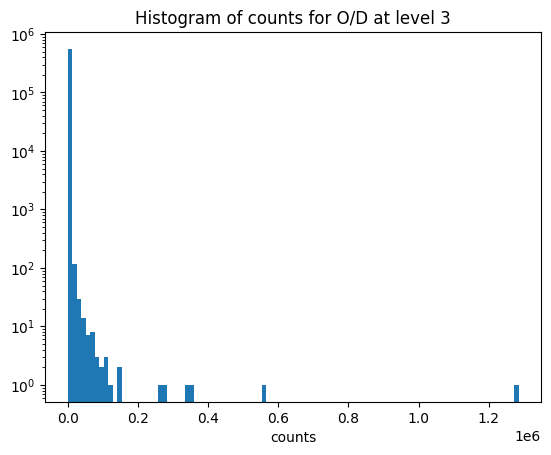

In [67]:
# make historga of count
import matplotlib.pyplot as plt

data_true = H.data_up_to_level(final_level, as_index=False, dtype=int)
plt.hist(data_true["COUNT"], bins=100, density=False, log=True)
plt.title(f"Histogram of counts for O/D at level {final_level}")
plt.xlabel("counts")
plt.show()

In [68]:
print("Sparsity of the data ", 1 - len(data_true) / (len(H.spine.get_nodes(level=final_level)) ** 2))

Sparsity of the data  0.9915070852277406


## Apply Stability Histogram

In [69]:
import argparse

epsilons = [1., 10.]
delta = 1E-8
num_experiments = 10
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(final_level + 1) for j in range(i, i + 2) if
                       j < final_level + 1]

# mechanisms, epsilons, experiments, levels
num_mechanisms = 2
max_error_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

# generate Namespace containing epsilon and delta
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, show_tqdm=True,
                          optimizer="greedy_integer", p='inf', integer_true=False, split_method='uniform')

In [70]:
from mechanism import VanillaSH
from metrics import analysis

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_vanillash, running_time_dense = VanillaSH(H, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_vanillash,
                                     spine=H.spine,
                                     workload=workload)
            max_error_sparse[0, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[0, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[0, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[0, e] = error_to_add
    std[0, e] = std_to_add

Experiment 10
Querying the full histogram
Applying the DP mechanism
Creating the dataset
Time taken to create the dataset: 17.29 seconds


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


## Apply GaussOpt

In [71]:
from mechanism import GaussOpt_destination

for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data_gaussopt, running_time_dense = GaussOpt_destination(H, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data_gaussopt,
                                     spine=H.spine,
                                     workload=workload)
            max_error_sparse[1, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[1, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[1, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[1, e] = error_to_add
    std[1, e] = std_to_add

Experiment 10
Level orig 0/3, Level dest 1/3 performing optimization...


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Level orig 1/3, Level dest 1/3 performing optimization...


100%|██████████| 20/20 [00:00<00:00, 49.21it/s]


Level orig 1/3, Level dest 2/3 performing optimization...


100%|██████████| 256/256 [00:04<00:00, 62.49it/s]


Level orig 2/3, Level dest 2/3 performing optimization...


100%|██████████| 1000/1000 [00:14<00:00, 67.53it/s]


Level orig 2/3, Level dest 3/3 performing optimization...


100%|██████████| 4208/4208 [01:33<00:00, 44.90it/s]


Level orig 3/3, Level dest 3/3 performing optimization...


100%|██████████| 42115/42115 [13:46<00:00, 50.95it/s]


Time taken to create the dataset: 942.26 seconds
Done!


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


## Maximum Absolute Error per Level

In [72]:
mechanisms = ["VanillaSH", "GaussOpt"]
markers = [["-s", "-o"], ["--s","--o"]]
colors = ["blue", "green"]

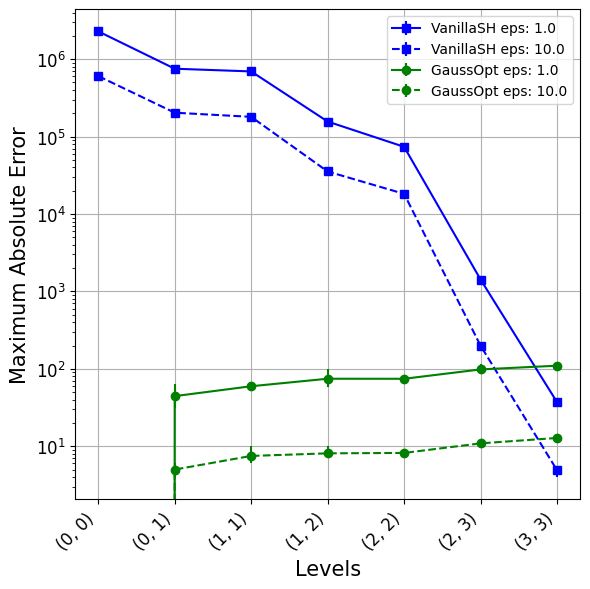

In [73]:
# plot line
import matplotlib.pyplot as plt

array = max_error_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/Italy/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/Italy/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

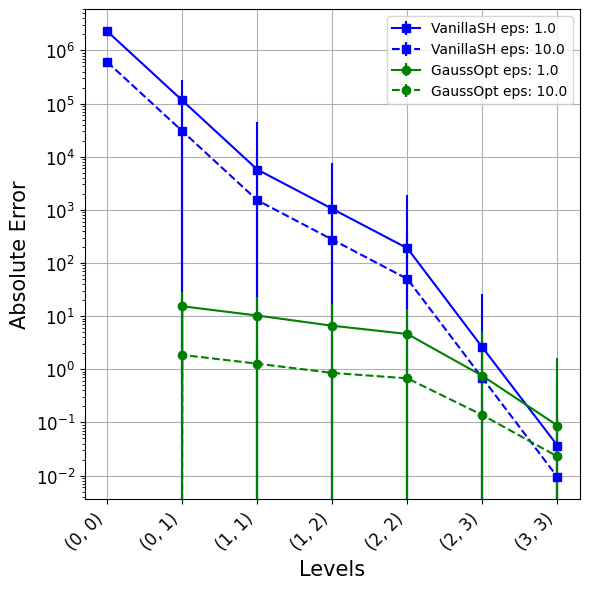

In [74]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/Italy/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/Italy/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

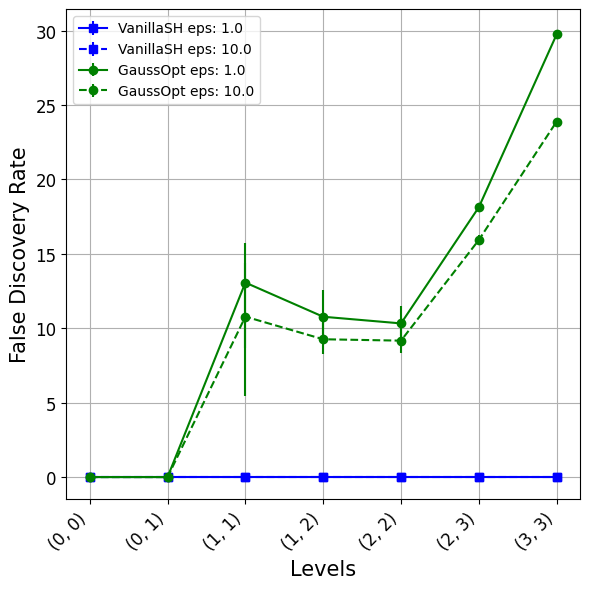

In [75]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        error = np.abs(error)
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../plots/Italy/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# save
plt.tight_layout()
plt.savefig(f"../plots/Italy/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

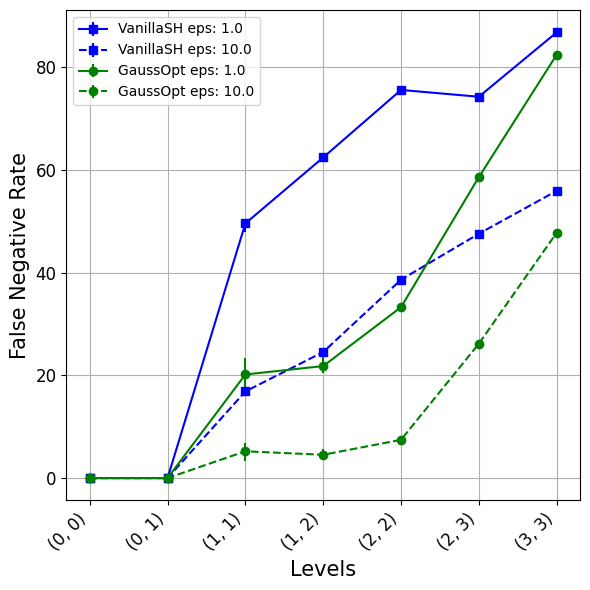

In [76]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_sparse
fig, ax = plt.subplots(figsize=(6, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save
plt.tight_layout()
plt.savefig(f"../plots/Italy/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
plt.savefig(f"../plots/Italy/false_negative_rate.pdf", dpi=300)
plt.show()

In [77]:
# save the results
with open("../results/Italy/results.pickle", "wb") as f:
    pickle.dump({"max_error_sparse": max_error_sparse,
                 "false_discovery_rate_sparse": false_discovery_rate_sparse,
                 "false_negative_rate_sparse": false_negative_rate_sparse,
                 "MAE": MAE,
                 "std": std}, f)